In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
import matplotlib.pyplot as plt
from packages.utils import plot_kfold


# Dataset import and cleaning

In [32]:
df = pd.read_csv('data/Auto.csv')
# df = pd.read_csv('https://github.com/vincenzorrei/EDU-Datasets/raw/refs/heads/main/Auto.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


The horsepower column is currently of type object, indicating that its data contains non-numeric values (e.g., strings or possibly missing/invalid entries). Since horsepower represents a numerical feature, it should ideally be converted to a numeric data type (float or int) for meaningful analysis or modeling.


In [33]:
# Find non-numeric values in the 'horsepower' column

# pd.to_numeric(errors='coerce'):
# Converts the column values to numeric, replacing those that cannot be converted with NaN.
nan_index = pd.to_numeric(df['horsepower'], errors='coerce').isna()

# Get the non-numeric values
non_numeric_values = df['horsepower'][nan_index]
print(non_numeric_values.value_counts())

horsepower
?    5
Name: count, dtype: int64


The presence of the value ? in your horsepower column is likely due to one of the following reasons:

- Data Entry Issues:
In the source data, ? might have been used as a placeholder for missing or unknown values instead of leaving the field blank or using a standard missing value indicator like NaN.

- Formatting in the Dataset:
If the data was extracted from a text file (e.g., CSV, TSV), ? might have been used as a way to indicate incomplete or invalid entries.

- Original Dataset Conventions:
In some older datasets, especially in UCI repositories or similar, ? is commonly used to signify "unknown" or "not applicable."

In [34]:
# Replace problematic values like '?' with NaN
df['horsepower'] = df['horsepower'].replace('?', np.nan)

# Convert 'horsepower' to numeric (non-numeric values become NaN)
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows where 'horsepower' is NaN
df.dropna(subset=['horsepower'], inplace=True)

print(df.isna().sum())


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64


In [35]:
# Create polynomial features
max_polynomial_degree = 10

for i in range(2, max_polynomial_degree+1):
    df[f'horsepower^{i}'] = df['horsepower'] ** i


## Select X and y

In [36]:
# Store the column names of the horsepower columns
horsepower_cols = [i for i in df.columns if 'horsepower' in i]

# Split the data into X and y
X = df[horsepower_cols]
y = df['mpg']

X.head()

,horsepower,horsepower^2,horsepower^3,horsepower^4,horsepower^5,horsepower^6,horsepower^7,horsepower^8,horsepower^9,horsepower^10
0,130.0,16900.0,2197000.0,285610000.0,3.712930e+10,4.826809e+12,6.274852e+14,8.157307e+16,1.060450e+19,1.378585e+21
1,165.0,27225.0,4492125.0,741200625.0,1.222981e+11,2.017919e+13,3.329566e+15,5.493784e+17,9.064743e+19,1.495683e+22
2,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
3,150.0,22500.0,3375000.0,506250000.0,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17,3.844336e+19,5.766504e+21
4,140.0,19600.0,2744000.0,384160000.0,5.378240e+10,7.529536e+12,1.054135e+15,1.475789e+17,2.066105e+19,2.892547e+21


# Train & Test split

In [37]:
t_prop = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_prop, random_state=42)

# 1. Validation Set Approach

The validation approach in data science and machine learning is a method for assessing the performance of a model on unseen data.

Its primary purpose is to ensure that the model generalizes well to new, unseen datasets. This approach involves splitting the available data into different sets (usually 50% vs- 50%) and evaluating the model using these subsets

In [38]:
# Dividing the dataset into training and val sets using cross-validation
prop = 0.5
X_train_cross, X_val, y_train_cross, y_val = train_test_split(X_train, y_train, test_size=prop, random_state=42)


In [39]:
# Choose the model
model = LinearRegression()
results = {}

# Create a loop
for i in range(1, len(horsepower_cols)+1):

    # Fit the model
    model.fit(X_train_cross[horsepower_cols[:i]], y_train_cross)
    # Predict the target variable
    y_val_pred = model.predict(X_val[horsepower_cols[:i]])
    # Calculate the MSE
    mse = mean_squared_error(y_val, y_val_pred)
    results[horsepower_cols[i-1]] = mse
    print(f'MSE for polynomial degree {i}: {mse:.4f}')


MSE for polynomial degree 1: 23.6798
MSE for polynomial degree 2: 19.2203
MSE for polynomial degree 3: 19.4173
MSE for polynomial degree 4: 19.4455
MSE for polynomial degree 5: 18.7473
MSE for polynomial degree 6: 18.5040
MSE for polynomial degree 7: 18.6417
MSE for polynomial degree 8: 18.8546
MSE for polynomial degree 9: 18.8182
MSE for polynomial degree 10: 18.6300


In [40]:
results

{'horsepower': np.float64(23.679768264415415),
 'horsepower^2': np.float64(19.220250464186286),
 'horsepower^3': np.float64(19.417250342613716),
 'horsepower^4': np.float64(19.445474737869922),
 'horsepower^5': np.float64(18.74730427434187),
 'horsepower^6': np.float64(18.504049374139345),
 'horsepower^7': np.float64(18.641731765342694),
 'horsepower^8': np.float64(18.85458924108725),
 'horsepower^9': np.float64(18.818177114429147),
 'horsepower^10': np.float64(18.629976496419317)}

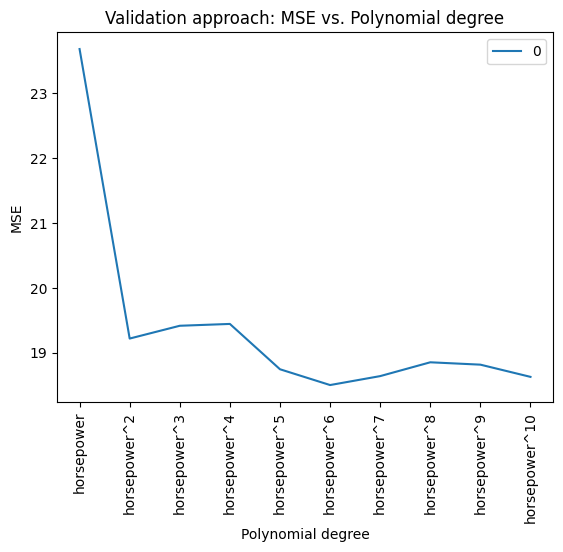

In [41]:
# Plot the results
results = pd.DataFrame([results])
results.T.plot()
plt.xlabel('Polynomial degree')
plt.xticks(ticks=range(len(results.columns)), labels=results.columns, rotation=90)
plt.ylabel('MSE')
plt.title('Validation approach: MSE vs. Polynomial degree')
plt.show()


# 2. K-Fold Cross Validation


The choice of the optimal number of 
𝑘
k in k-fold cross-validation is a trade-off between the accuracy of the model performance estimate and computational cost. Typically, a 
𝑘
k between 5 and 10 is used

##### (Optional) What's inside k-fold? Shuffle?

In [ ]:
# Example for Just horsepower

# Initialize the model and k-fold cross-validation
k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
model = LinearRegression()

# List to store MSE for each fold
mse_scores = []
X_train_single = X_train['horsepower']

# Perform k-fold cross-validation
for i, (train_index, val_index) in enumerate(kf.split(X_train_single)):
    # Split the data into training and test sets
    X_train_cross, X_val = X_train_single.iloc[train_index], X_train_single.iloc[val_index]
    y_train_cross, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Select only horsepower column
    X_train_cross = X_train_cross.values.reshape(-1, 1)
    
    # Train the model on the training set
    model.fit(X_train_cross, y_train_cross)
    
    # Predict on the test set
    y_pred = model.predict(X_val.values.reshape(-1, 1))
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val.values, y_pred)
    mse_scores.append(mse)
    # print(f"Fold {i}:")
    #print(f"  Training dataset index: {train_index}")
    print(f"\nTest dataset index: {val_index}")
    print(f"Mean MSE across {1} folds: {mse:.4f}")

# Calculate the mean and standard deviation of MSE
mean_mse = np.mean(mse_scores)

# Output the results
print(f"{'-'*30}\nMean MSE across {k} folds: {mean_mse:.4f}")


Test dataset index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
Mean MSE across 1 folds: 26.5273

Test dataset index: [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194
 195 196 197 198 199 200 201 202 203 204 205 206 207 208]
Mean MSE across 1 folds: 25.8948

Test dataset index: [209 210 211 212 213 

#### How to K-Fold Cross validation

In [58]:
# Create the scorer for Mean Squared Error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize the linear regression model
regr = LinearRegression()

# Create the K-Fold cross-validator
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation measuring the Mean Squared Error
scores = cross_val_score(
    regr, X_train, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1
) # you can simply use scoring='accuracy' instead of mse_scorer in classification problems

# Calculate the mean of the MSE scores
mean_mse = -scores.mean()  # Invert the sign because greater_is_better=False
print(f"Mean Squared Error (average): {mean_mse}")


Mean Squared Error (average): 19.411547282135963


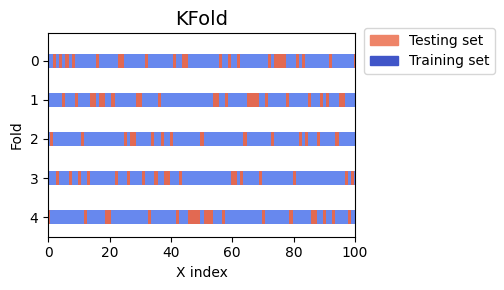

In [59]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
plot_kfold(cv, X_train, y_train, ax, 5)
plt.tight_layout()
fig.subplots_adjust(right=0.6)

# 3. Leave One Out Cross Validation (LOOCV)

In [ ]:
# Create the LOOCV cross-validator
cv = LeaveOneOut()

# Perform cross-validation measuring the Mean Squared Error
scores = cross_val_score(
    regr, X_train, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1
) # you can simply use scoring='accuracy' instead of mse_scorer in classification problems

# Calculate the mean of the MSE scores
mean_mse = -scores.mean()  # Invert the sign because greater_is_better=False
print(f"Mean Squared Error (average): {mean_mse}")


Mean Squared Error (average): 19.257471634638375
